In [1]:
# Bibliotecas necessárias para o experimento

import numpy as np, numpy.random
import matplotlib.pyplot as plt
from random import randint
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from random import randint, uniform, random
from scipy.linalg import sqrtm

In [2]:
## CONSTANTES PARA O ALGORITMO GENÉTICO

ELITISMO = True
PORCENTAGEM_ELITISMO = 0.20

TAMANHO_POP = 50
TAXA_MUTACAO = 0.10
TAXA_CRUZAMENTO = 0.70
GERACOES = 100

# Valores mínimos e máximos para gerar uma população
MIN = 0
MAX = 200
 # 115, 150

In [3]:
def S(Ut, Uf, X):
    W = np.dot(np.transpose(Uf), Ut)
    T = np.transpose(W)
    A = np.dot(np.transpose(Ut), np.transpose(X))
    C = np.dot(A, Uf)
    L = W - np.identity(3) - 1/2*(W - np.identity(3))**2
    S = 2*np.trace(np.dot((-np.dot(T, C) + 2*C),L))
    #S = 2*np.trace(np.dot((-1/2*np.dot(C, T) - 1/2*np.dot(T, C) + 2*C),L))
    return S

In [4]:
def field(Ut, Uf, a, h, A, B):
    SA = S(Ut, Uf, A)
    SB = S(Ut, Uf, B)
    f = -a*SA-h*(SB/SA)
    return f

In [5]:
def lind(u, Ut, Uf, t, lbda):
    n = 1
    Ax = [[0, 0, 0],[0, 0, -1], [0, 1, 0]]
    Ay = [[0, 0, 1],[0, 0, 0], [-1, 0, 0]]
    Az = [[0, -1, 0],[1, 0, 0], [0, 0, 0]]
    B = [[(1-n*2)*lbda, 0, 0],[0, (1-n*2)*lbda, 0], [0, 0, (-n*2)*lbda]] # Amplitude Damping
    #B = [[-1.01*lbda, 0, 0],[0, -1.01*lbda, 0], [0, 0, -0.01*lbda]] # Phase Damping
    if t == 0:
        fx = u[0]
        fy = u[1]
        fz = u[2]
        F=np.dot(u[0],Ax)+np.dot(u[1],Ay)+np.dot(u[2],Az)+B
    else:
        fx=field(Ut, Uf, u[0], 0.35, Ax, B)
        fy=field(Ut, Uf, u[1], 0.31, Ay, B)
        fz=field(Ut, Uf, u[2], 0.34, Az, B)
        P=400

        if abs(fx) > P:
            if fx < 0:
                fx = -P
            else:
                fx = P
        if abs(fy) > P:
            if fy < 0:
                fy = -P
            else:
                fy = P
        if abs(fz) > P:
            if fz < 0:
                fz = -P
            else:
                fz = P

        F=np.dot(fx,Ax)+np.dot(fy,Ay)+np.dot(fz,Az)+B
        	
    return fx,fy,fz,F

In [6]:
def rungeKutta(u, Ut, Uf, h, t, lbda):

    if t == 0:
        
        fx,fy,fz,k1 = lind(u, Ut, Uf, t, lbda)
        k1 = np.dot(k1,Ut)
        fx,fy,fz,k2 = lind(u, (Ut+h/2*k1), Uf, t, lbda)
        k2 = np.dot(k2,(Ut+h/2*k1))
        fx,fy,fz,k3 = lind(u, (Ut+h/2*k2), Uf, t, lbda)
        k3 = np.dot(k3,(Ut+h/2*k2))
        fx,fy,fz,k4 = lind(u, (Ut+h*k3), Uf, t, lbda)
        k4 = np.dot(k4,(Ut+h*k3))
        a = fx;
        b = fy;
        c = fz;

    else:

        fx,fy,fz,k1 = lind(u, Ut, Uf, t, lbda)
        k1 = np.dot(k1,Ut)
        fx,fy,fz,k2 = lind(u, (Ut+h/2*k1), Uf, t+h/2, lbda)
        k2 = np.dot(k2,(Ut+h/2*k1))
        fx,fy,fz,k3 = lind(u, (Ut+h/2*k2), Uf, t+h/2, lbda)
        k3 = np.dot(k3,(Ut+h/2*k2))
        fx,fy,fz,k4 = lind(u, (Ut+h*k3), Uf, t+h, lbda)
        k4 = np.dot(k4,(Ut+h*k3))
        a = fx;
        b = fy;
        c = fz;

    
    result = Ut+(h/6)*(k1+2*k2+2*k3+k4);
    return a,b,c,result

In [7]:
def func_objetivo(u, Ut, Uf, h, tempo, lbda):
    a, b, c, Ut1 = rungeKutta(u, Ut, Uf, h, tempo, lbda)
    return (np.linalg.norm(Ut1-Uf))**2

In [8]:
def gerar_populacao():
    populacao = np.zeros((TAMANHO_POP,3))
    for individuo in range(TAMANHO_POP):
        for genes in range(3):
            populacao[individuo,genes] = uniform(MIN, MAX)
    return populacao

In [9]:
def calcular_func(populacao, Ut, Uf, h, tempo, TAMANHO_POP, lbda):
    valor_func = np.zeros(TAMANHO_POP)
    for individuo in range(TAMANHO_POP):
        valor_func[individuo] = func_objetivo(populacao[individuo,:], Ut, Uf, h, tempo, lbda)
    return valor_func

In [10]:
def selecao(valor_fitness):
    pos = np.random.choice(range(TAMANHO_POP), 2, replace=False)
    valor = valor_fitness[pos[0]] < valor_fitness[pos[1]]
    if valor == True:
        return pos[0]
    else:
        return pos[1]

In [11]:
def divisao_fitness(valor_funcao_objetivo):
    divisao = 0
    for i in range(len(valor_funcao_objetivo)):
        divisao += valor_funcao_objetivo[i]
    return divisao

def fitness(valor_funca_objetivo):
    return valor_funca_objetivo/divisao_fitness(valor_funca_objetivo)

In [12]:
def cruzamento(pai1, pai2):
    x = random()
    filho1 = x*pai1+(1-x)*pai2
    filho2 = (1-x)*pai1+x*pai2
    return filho1, filho2

In [13]:
def mutacao(individuo, horizonte):
    
    # Gaussian function
    for i in range (0, horizonte):
        if random() < TAXA_MUTACAO:
            individuo[i] = (1/np.sqrt(2*np.pi))*np.exp((-1/2*(uniform(MIN, MAX)-2)**2))
    
    return individuo

In [14]:
def genetico(Ut, Uf, h, tempo, TAMANHO_POP, lbda):
    
    horizonte = 3
    pop = gerar_populacao()
    fo = calcular_func(pop, Ut, Uf, h, tempo, TAMANHO_POP, lbda)
    fit = fitness(fo)
    fit_edit = fit
    min_fit = min(fit)
            
    melhor_fo = np.zeros(GERACOES)
    for geracao in range(GERACOES):
        new_pop = np.empty((0, horizonte))
        for i in range(round((TAMANHO_POP)/2)):
            pai1 = 0
            pai2 = 0
            while pai1 == pai2:
                pai1 = selecao(fit)
                pai2 = selecao(fit)
            if random() < TAXA_CRUZAMENTO:
                filho1, filho2 = cruzamento(pop[pai1, :], pop[pai2, :])
                filho1 = mutacao(filho1, horizonte)
                filho2 = mutacao(filho2, horizonte)
                new_pop = np.vstack([new_pop, filho1, filho2])
            else:
                pais = np.vstack([mutacao(pop[pai1, :], horizonte), mutacao(pop[pai2, :], horizonte)])
                new_pop = np.vstack([new_pop, pais])

        pop = new_pop
        fo = calcular_func(pop, Ut, Uf, h, tempo, TAMANHO_POP, lbda)
        fit = fitness(fo)
        min_fo = min(fo)
        melhor_fo[geracao] = min_fo
        pos_min_fo = np.where(fo == min_fo)
                
    return pop[pos_min_fo,:][0,0]

In [15]:
def leis_controle(fx, fy, fz, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    plt.ylabel("Valores das leis de controle") 
    plt.xlabel('Tempo (u. a.)') 
    plt.plot(ts, fx, color='g', marker='o', linewidth=1, markersize=1, label="$f_x(t)$")
    plt.plot(ts, fy, color='b', marker='_', linewidth=1, markersize=1, label="$f_y(t)$")
    plt.plot(ts, fz, color='r', marker='.', linewidth=1, markersize=1, label="$f_z(t)$")
    plt.legend(loc="upper right")
    plt.title(fr"Leis de controle para $\gamma = {lbda}$")
    plt.show()

In [16]:
def fidelidade(fid, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel("Valores de fidelidade") 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Fidelidade com $\gamma = {lbda}$")

    x1, x2, y1, y2 = 2.5, 4, 0, max(np.abs(fid))
    axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    axins.set_xlim(0.009, 0.020)
    axins.set_ylim(0.98, 1)

    axins.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.indicate_inset_zoom(axins)
    
    plt.show()

In [17]:
def distance(fid, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel("Valores de distância") 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Distância entre os operadores de evolução com $\gamma = {lbda}$")

    #x1, x2, y1, y2 = 2.5, 4, 0, max(np.abs(fid))
    #axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    #axins.set_xlim(0.009, 0.020)
    #axins.set_ylim(0.98, 1)

    #axins.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    #ax.indicate_inset_zoom(axins)
    
    plt.show()

In [18]:
def densidade(rho, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel('Valores da matriz de densidade') 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, abs(rho[0]), color='g', marker='o', linewidth=1, markersize=1, label=r"$\rho_{00}$")
    ax.plot(ts, abs(rho[1]), color='b', marker='8', linewidth=1, markersize=1, label=r"$\rho_{01}$")
    ax.plot(ts, abs(rho[2]), color='r', marker='.', linewidth=1, markersize=1, label=r"$\rho_{10}$")
    ax.plot(ts, abs(rho[3]), color='y', marker='*', linewidth=1, markersize=1, label=r"$\rho_{11}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Evolução da matriz de densidade $\gamma = {lbda}$")

    x1, x2, y1, y2 = 2.5, 4, 0, max(max(abs(rho[0])), max(abs(rho[1])), max(abs(rho[2])), max(abs(rho[3])))
    axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    axins.set_xlim(0.009, 0.020)
    axins.set_ylim(0.98, 1)

    axins.plot(ts, abs(rho[0]), color='g', marker='o', linewidth=1, markersize=1, label=r"$\rho_{00}$")
    axins.plot(ts, abs(rho[1]), color='b', marker='8', linewidth=1, markersize=1, label=r"$\rho_{01}$")
    axins.plot(ts, abs(rho[2]), color='r', marker='.', linewidth=1, markersize=1, label=r"$\rho_{10}$")
    axins.plot(ts, abs(rho[3]), color='y', marker='*', linewidth=1, markersize=1, label=r"$\rho_{11}$")

    ax.indicate_inset_zoom(axins)
    
    plt.show()

In [19]:
def main():
    r = 1
    aas = []
    u = [70, 106, 66, 0.35, 0.31, 0.34] # Hadamard
    
    Ut = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
    Uf = [[0, 0, 1], [0, -1, 0], [1, 0, 0]] # Hadamard
    
    r0 = [[1], [0], [0]]
    rf = np.dot(Uf, r0)
    pf = [[1/2*(1+rf[2][0]), 1/2*(rf[0][0]-1j*rf[1][0])], [1/2*(rf[0][0]+1j*rf[1][0]), 1/2*(1-rf[2][0])]]
    
    h=0.001
    t=0
    i=0
    lbda=0.01
    # Proposta do algoritmo genético
    resultado_algoritmo_genetico = genetico(Ut, Uf, h, t, TAMANHO_POP, lbda) 
    u[0] = resultado_algoritmo_genetico[0]
    u[1] = resultado_algoritmo_genetico[1]
    u[2] = resultado_algoritmo_genetico[2]
    aas.append((u[0],u[1],u[2]))
    distance_vector = []
    fx_vector = []
    fy_vector = []
    fz_vector = []
    rho_vector = np.zeros((4,1000),dtype=np.complex128)
    fid_vector = []
    fid_autores = []
       
    while t < 100:
        
        a,b,c,Uto = rungeKutta(u, Ut, Uf, h, t, lbda)
        D = np.linalg.norm(Uto-Uf)**2
        distance_vector.append(D)
        fx_vector.append(a)
        fy_vector.append(b)
        fz_vector.append(c)
        rt = np.dot(Uto, r0)
        pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
        rho_vector[0][t] = pt[0][0]
        rho_vector[1][t] = pt[0][1]
        rho_vector[2][t] = pt[1][0]
        rho_vector[3][t] = pt[1][1]
        fid_vector.append((np.trace(sqrtm(sqrtm(pt) @ pf @ sqrtm(pt))))**2)
        fid_autores.append((np.trace(np.dot(Uto, np.transpose(Uto)))+np.abs(np.trace(np.dot(np.transpose(Uf), Uto)))**2)/(3*(3+1)))
        if not (1/2*(1+rt[2][0]) > 1 or fid_autores[-1] > 1 or fid_vector[-1] > 1):
            resultado_algoritmo_genetico = genetico(Uto, Uf, h, t, TAMANHO_POP, lbda) 
            u[0] = resultado_algoritmo_genetico[0]
            u[1] = resultado_algoritmo_genetico[1]
            u[2] = resultado_algoritmo_genetico[2]
        aas.append((u[0],u[1],u[2]))
        
        print(f"Distância: {distance_vector[-1]}")
        print(f"Fidelidade: {fid_vector[-1]}")
        print(f"Fidelidade da porta: {fid_autores[-1]}")
        t += 1
        Ut = Uto
        

    print(f"O rho gerado foi: {pt}") 
    print(f"A matriz de evolução Ut gerada foi: {Ut}")
    print(f"Portanto, a distância gerada foi: {D}")
    rt = np.dot(Ut, r0)
    pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
    
    #leis_controle(fx_vector,fy_vector,fz_vector,t,lbda)
    #densidade(rho_vector,t,lbda)
    #fidelidade(fid_vector,t,lbda)
    #fidelidade(fid_autores,t,lbda)
    #distance(distance_vector,t,lbda)

    return fid_vector, fid_autores, rho_vector, distance_vector, fx_vector, fy_vector, fz_vector, aas

In [20]:
import matplotlib.pyplot as plt

def histograma(componente, valores_as):

    valores = []
    # Extração dos valores para o componente escolhido
    valores_intermediarios = [sublista for sublista in a]
    for i in valores_intermediarios:
        valores.append(i[componente])
    
    # Criação do histograma
    plt.hist(valores, bins=10, edgecolor='black')
    plt.xlabel(f'Componente {["x", "y", "z"][componente]}')
    plt.ylabel('Frequência')
    plt.title(f'Histograma do Componente {["x", "y", "z"][componente]}')
    plt.show()


Começará a função principal
Distância: 7.906683398745834
Fidelidade: (0.5058257555590128-7.73112741317246e-10j)
Fidelidade da porta: 0.3257380444238021
Distância: 6.837585477435537
Fidelidade: (0.5729253997623719+5.657874967866527e-09j)
Fidelidade da porta: 0.2645654865013138
Distância: 4.886115095140298
Fidelidade: (0.6946706167872859+4.282087492619055e-09j)
Fidelidade da porta: 0.2755908165436479
Distância: 2.659351076157009
Fidelidade: (0.8336378408942047+3.6393907105840237e-09j)
Fidelidade da porta: 0.48184431256490884
Distância: 0.8694857039062014
Fidelidade: (0.9454054089564201+3.4797454152264358e-09j)
Fidelidade da porta: 0.7971598424777806
Distância: 0.22721873988742278
Fidelidade: (0.9867412696929893+2.451793951048955e-09j)
Fidelidade da porta: 0.9454461686178082
Distância: 0.06125299248176986
Fidelidade: (0.9967649469557178-2.317434651944213e-13j)
Fidelidade da porta: 0.9863671627239414
Distância: 0.017402575091151735
Fidelidade: (0.9992353914064362-6.212515425806734e-10j)
Fi

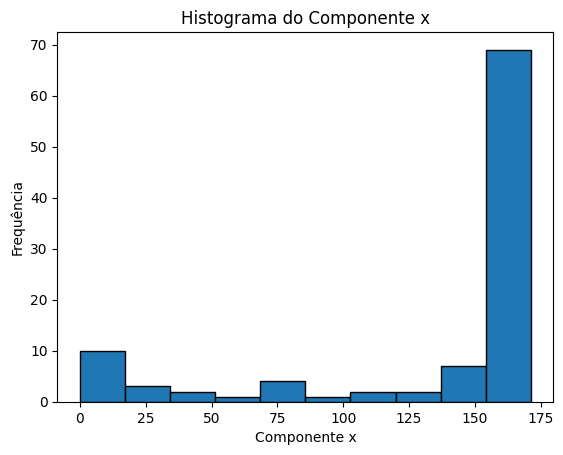

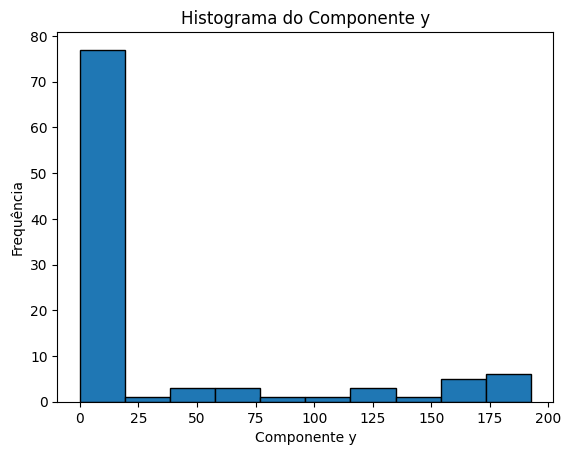

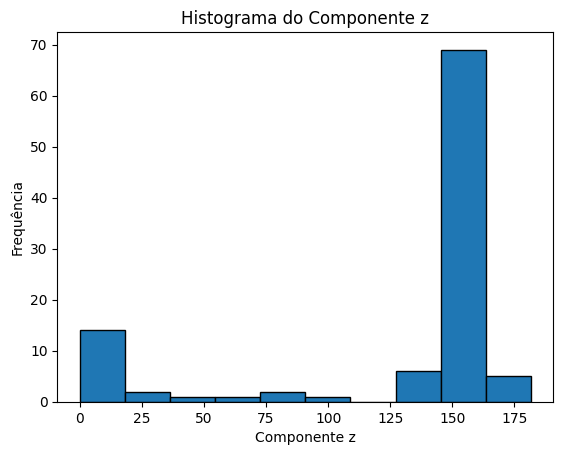

Terminou o histograma
Valores de média na iteração 1:
Portas: 0.9993050361573729
Estados: (0.9994145899046534-9.012085563062915e-12j)
Distância: 2.7301175412423153e-06
 


In [21]:
portas = []
estados = []
distancia = []
i = 1

print(f"Começará a função principal")
fid_vector, fid_autores, rho_vector, distance_vector, fx_vector, fy_vector, fz_vector, a = main()
print(f"Terminou a função principal")
print(f"Veja o log: (Dos estados)")
print(fid_vector)
print(f"Veja o log: (Das portas)")
print(fid_autores)

portas.append(fid_autores[-1])
estados.append(fid_vector[-1])
distancia.append(distance_vector[-1])

print(f"Começou o histograma")
histograma(0, a)
histograma(1, a)
histograma(2, a)
print(f"Terminou o histograma")

print(f"Valores de média na iteração {i}:")
print(f"Portas: {sum(portas)/i}")
print(f"Estados: {sum(estados)/i}")
print(f"Distância: {sum(distancia)/i}")
print(" ")

In [22]:
fid_vector

[(0.5058257555590128-7.73112741317246e-10j),
 (0.5729253997623719+5.657874967866527e-09j),
 (0.6946706167872859+4.282087492619055e-09j),
 (0.8336378408942047+3.6393907105840237e-09j),
 (0.9454054089564201+3.4797454152264358e-09j),
 (0.9867412696929893+2.451793951048955e-09j),
 (0.9967649469557178-2.317434651944213e-13j),
 (0.9992353914064362-6.212515425806734e-10j),
 (1.000033641557214+2.813908546945841e-10j),
 (1.0002287372674117+9.859155847178537e-11j),
 (1.0002710015448535-2.5957814954607565e-11j),
 (1.0002743249783652+7.028075539224387e-11j),
 (1.0002677144227201+1.833208754942839e-17j),
 (1.0002585704847344-8.90402823273468e-12j),
 (1.0002487816706918-6.639435377772367e-12j),
 (1.0002388295860634+5.596837381297783e-12j),
 (1.0002288366063836-1.1599836922192293e-11j),
 (1.0002188336849451-4.116349616160317e-11j),
 (1.0002088285735982-6.0424288606781164e-12j),
 (1.0001988231633308-2.646741820970551e-12j),
 (1.000188817773531+5.687345238167834e-13j),
 (1.0001788126405688-5.5512465965

In [23]:
fid_autores

[0.3257380444238021,
 0.2645654865013138,
 0.2755908165436479,
 0.48184431256490884,
 0.7971598424777806,
 0.9454461686178082,
 0.9863671627239414,
 0.9973226532940241,
 1.0004599947807293,
 1.0013037887234797,
 1.0015189127036144,
 1.0015598660386489,
 1.0015522069767178,
 1.0015308928536824,
 1.001505720475229,
 1.0014794521815824,
 1.0014528713591877,
 1.0014262013787019,
 1.001399506259115,
 1.001372804447603,
 1.0013461012830935,
 1.0013193983206394,
 1.0012926960188382,
 1.0012659945160325,
 1.0012392938547103,
 1.001212594048022,
 1.001185895100041,
 1.001159197012017,
 1.0011324997843207,
 1.0011058034170481,
 1.0010791079102084,
 1.0010524132637855,
 1.0010257194777539,
 1.000999026552086,
 1.0009723344867532,
 1.000945643281726,
 1.0009189529369764,
 1.0008922634524746,
 1.000865574828192,
 1.0008388870640996,
 1.000812200160168,
 1.0007855141163688,
 1.0007588289326732,
 1.0007321446090516,
 1.0007054611454758,
 1.000678778541916,
 1.000652096798344,
 1.0006254159147308,
 1.

In [24]:
rho_vector

array([[0.50582574+0.j        , 0.57292539+0.j        ,
        0.6946706 +0.j        , ..., 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.49422001-0.07554778j, 0.42760012-0.24855152j,
        0.30585835-0.3441396j , ..., 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.49422001+0.07554778j, 0.42760012+0.24855152j,
        0.30585835+0.3441396j , ..., 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.49417426+0.j        , 0.42707461+0.j        ,
        0.3053294 +0.j        , ..., 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ]])

In [25]:
distance_vector

[7.906683398745834,
 6.837585477435537,
 4.886115095140298,
 2.659351076157009,
 0.8694857039062014,
 0.22721873988742278,
 0.06125299248176986,
 0.017402575091151735,
 0.004834232851425366,
 0.001379627437007835,
 0.00041999935781820747,
 0.00015144520861177878,
 7.579025764685752e-05,
 5.43305631912421e-05,
 4.818920862244011e-05,
 4.640262932383654e-05,
 4.586110150220665e-05,
 4.5677722709347415e-05,
 4.559819468878827e-05,
 4.554932522760988e-05,
 4.5510015782070986e-05,
 4.547414356940938e-05,
 4.543989718676856e-05,
 4.5406726653257136e-05,
 4.537446233390715e-05,
 4.5343051527934754e-05,
 4.5312477789189854e-05,
 4.5282735952516035e-05,
 4.525382436941491e-05,
 4.52257424889598e-05,
 4.5198490103102135e-05,
 4.5172067110992694e-05,
 4.514647344532001e-05,
 4.5121709049268745e-05,
 4.509777386930901e-05,
 4.5074667852936815e-05,
 4.5052390947964074e-05,
 4.5030943102295383e-05,
 4.501032426385686e-05,
 4.499053438056927e-05,
 4.497157340033958e-05,
 4.4953441271052245e-05,
 4.49

In [26]:
fx_vector

[153.62356791133564,
 400,
 400,
 400,
 366.97532774262015,
 148.13039405495414,
 73.68522823018138,
 37.43990589450251,
 21.090743028921825,
 10.646818403737825,
 5.380389209619767,
 2.71964923005356,
 1.374191663895741,
 0.6929131412044741,
 0.34648737284887854,
 0.16792218849406673,
 0.07309724556665642,
 0.02364564800612385,
 0.004614838027539876,
 0.001039297761027333,
 0.0008632164493016514,
 0.0009438887945757771,
 0.000988079322251409,
 0.0010113638463839017,
 0.0010281968988220883,
 0.00104356834987418,
 0.001058990085036557,
 0.0010749284104646997,
 0.0010915535813086907,
 0.0011089566871285012,
 0.0011272116729886539,
 0.0011463935231503866,
 0.001166584265509335,
 0.001187875754723025,
 0.0012103717910353362,
 0.0012341903481124586,
 0.0012594662023391323,
 0.001286354148524238,
 0.0013150329904322022,
 0.0013457105448389794,
 0.0013786299795953208,
 0.0014140779279542756,
 0.0014523949974080547,
 0.0014939895553607516,
 0.0015393560685051585,
 0.0015890998847728627,
 0.001

In [27]:
fy_vector

[1.2578909802240196e-07,
 -0.08452637697560116,
 -0.012717422863747928,
 0.001025836485994826,
 0.03529484117657025,
 -0.03349167388975405,
 -0.007957495240101331,
 -0.0028653086561425244,
 0.0002846929751811204,
 0.000814895666104844,
 0.0009462218239401401,
 0.0009678976989018935,
 0.0009592657170910355,
 0.0009422130434810971,
 0.0009228135672202716,
 0.0009027626298185916,
 0.0008825358372308104,
 0.0008622669806908717,
 0.0008419936346809542,
 0.0008217264153946421,
 0.0008014682687752372,
 0.0007812198403238885,
 0.0007609810807619865,
 0.0007407517629178915,
 0.0007205316244209207,
 0.0007003203964296049,
 0.0006801178090130223,
 0.0006599235923461384,
 0.0006397374770224009,
 0.0006195591941332208,
 0.0005993884752835298,
 0.0005792250525813369,
 0.0005590686586239087,
 0.0005389190264809289,
 0.000518775889676119,
 0.0004986389821698761,
 0.00047850803834123225,
 0.00045838279297025366,
 0.00043826298122020147,
 0.00041814833862020416,
 0.00039803860104672446,
 0.0003779335047

In [28]:
fz_vector

[152.2846507778773,
 400,
 400,
 400,
 364.3188765764743,
 142.98471204809147,
 76.3390919612056,
 40.77421755384114,
 20.833995566550108,
 11.36560126408125,
 6.2081417360130144,
 3.392247778788599,
 1.8535155223803226,
 1.0121129213222937,
 0.5513585789664316,
 0.29800574619425224,
 0.15711561281100117,
 0.07708665891638337,
 0.0319888739049927,
 0.01047028446883886,
 0.003341317466360315,
 0.001610810285100156,
 0.00120787519153924,
 0.0011086624277126048,
 0.001089219987681092,
 0.0010936850077399307,
 0.0011060481544736614,
 0.0011214126378354186,
 0.0011382674699098247,
 0.0011561725410219673,
 0.0011750340998904624,
 0.0011948749503090592,
 0.0012157618186776423,
 0.0012377831417061252,
 0.0012610432368950694,
 0.0012856620107121186,
 0.001311776800555671,
 0.0013395453572896537,
 0.0013691497806242944,
 0.0014008015249307101,
 0.001434747755745723,
 0.001471279483355327,
 0.0015107420819445022,
 0.0015535490648192762,
 0.001600200374395313,
 0.001651307044588407,
 0.00170762503

In [29]:
a

[(153.62356791133564, 1.2578909802240196e-07, 152.2846507778773),
 (170.59515634908857, 0.004291762020052788, 180.9876916864655),
 (41.106418051705866, 2.6569530741351256e-14, 47.32005159778662),
 (68.67060538785567, 1.971706723845671e-12, 86.67262976715921),
 (149.86034651023223, 0.0, 141.65479236949238),
 (152.15310271077396, 0.00018446062530525463, 137.04477492073875),
 (160.76512147070213, 2.578325653612119e-60, 153.4533529271304),
 (147.64224421102077, 0.05170471286889543, 163.0870341191515),
 (171.2783108544543, 0.0, 150.84537684751297),
 (171.2783108544543, 0.0, 150.84537684751297),
 (171.2783108544543, 0.0, 150.84537684751297),
 (171.2783108544543, 0.0, 150.84537684751297),
 (171.2783108544543, 0.0, 150.84537684751297),
 (171.2783108544543, 0.0, 150.84537684751297),
 (171.2783108544543, 0.0, 150.84537684751297),
 (171.2783108544543, 0.0, 150.84537684751297),
 (171.2783108544543, 0.0, 150.84537684751297),
 (171.2783108544543, 0.0, 150.84537684751297),
 (171.2783108544543, 0.0, 1